<a href="https://colab.research.google.com/github/nitaifingerhut/cs236608/blob/master/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neccesary code from last workshop
No need to understand it.

In [1]:
# Reclab installation. this may take a minute or two
!pip install pybind11
!pip install reclab[recommenders]
!cp /usr/local/lib/python3.7/dist-packages/wpyfm/pyfm.cpython-36m-x86_64-linux-gnu.so /usr/local/lib/python3.7/dist-packages/wpyfm/pyfm.so
!git clone https://github.com/berkeley-reclab/RecLab /usr/local/lib/python3.7/dist-packages/reclab2
!cp -a /usr/local/lib/python3.7/dist-packages/reclab2/reclab/recommenders/. /usr/local/lib/python3.7/dist-packages/reclab/recommenders/

fatal: destination path '/usr/local/lib/python3.7/dist-packages/reclab2' already exists and is not an empty directory.


In [2]:
import numpy as np
import reclab
import matplotlib.pyplot as plt
from reclab.environments import Topics
from reclab.environments.latent_factors import LatentFactorBehavior
from reclab.recommenders import TopPop
from reclab.recommenders.libfm import LibFM
from tqdm import tqdm
%config InlineBackend.figure_format = 'retina'

In [3]:
import scipy.sparse
import wpyfm
from reclab.recommenders.libfm import LibFM

class LibFM_MLHB(LibFM):
  def get_predictions_with_promotions(self, user_item, predictions):
    assert hasattr(self, '_spendings') and hasattr(self, '_item_topics')
    sorted_suppliers = np.argsort(self._spendings)
    for i, (_, item_id_inner, _) in enumerate(user_item):
      item_id = self._inner_to_outer_iid[item_id_inner]
      supplier = self._item_topics[item_id]
      supplier_place = np.where(sorted_suppliers == supplier)[0][0]
      prediction_bias = float(supplier_place)/len(sorted_suppliers)*2 - 1
      predictions[i] += prediction_bias
    return predictions

  def _predict(self, user_item):  # noqa: D102
    # Create a test_inputs array that can be parsed by our output function.
    test_inputs = []
    data = []
    row_col = [[], []]
    for row, (user_id, item_id, rating_context) in enumerate(user_item):
        user_features = self._users[user_id]
        item_features = self._items[item_id]
        row_col[0].append(row)
        row_col[1].append(user_id)
        data.append(1)
        for i, feature in enumerate(user_features):
            row_col[0].append(row)
            row_col[1].append(self._max_num_users + i)
            data.append(feature)
        row_col[0].append(row)
        row_col[1].append(self._max_num_users + len(user_features) + item_id)
        data.append(1)
        for i, feature in enumerate(item_features):
            row_col[0].append(row)
            row_col[1].append(self._max_num_users + len(user_features) +
                              self._max_num_items + i)
            data.append(feature)
        for i, feature in enumerate(rating_context):
            row_col[0].append(row)
            row_col[1].append(self._max_num_users + len(user_features) +
                              self._max_num_items + len(item_features) + i)
            data.append(feature)

    test_inputs = scipy.sparse.csr_matrix((data, row_col),
                                          shape=(len(user_item), self._num_features))
    test_data = wpyfm.Data(test_inputs, np.zeros(test_inputs.shape[0]), has_xt=self._has_xt)
    predictions = self._model.predict(test_data)

    return self.get_predictions_with_promotions(user_item, predictions)

  def reset(self, users=None, items=None, ratings=None):  # noqa: D102
    np.random.seed(0)
    rating_inputs = scipy.sparse.csr_matrix((0, self._num_features))
    rating_outputs = np.empty((0,))
    self._train_data = wpyfm.Data(rating_inputs, rating_outputs, has_xt=self._has_xt)
    super().reset(users, items, ratings)
    self._model.train(self._train_data)

In [4]:
def RMSE(env, recommender):
  true_ratings = env.dense_ratings
  predicted_ratings = recommender.dense_predictions
  return np.sqrt(np.mean((predicted_ratings-true_ratings)**2))

def avg_rec_rating(env, recommender):
  all_users = env.users
  recommendations, _ = recommender.recommend(all_users, 1)
  true_ratings = env.dense_ratings
  sum = 0
  for i, item in enumerate(recommendations):
    sum += true_ratings[i, item[0]]
  return sum/(len(all_users))

In [5]:
from tqdm import tqdm

"""
params:
env - reclab environment.
recommender - reclab recommender.
steps - number of simulation iterations. in each step the recommender recommends items to online users and gets their true ratings.
rpu - recommendations per user.
retrain - retrain model after each step (True) or not (False).
callbacks - a list of functions. each gets (env, recommender) as arguments. before every timestep all callbacks are invoked.
reset - reset the environment and recommender at the beggining of the simulation (True) or not (False)

return:
a list of lists. Each list contains the return values of its corresponding callback for all timesteps.
"""
def simulation(env, recommender, steps=100, rpu=1, retrain=True, callbacks=None, reset=True):
  if reset:
    np.random.seed(0)
    env.seed(0)
    if hasattr(env, '_topic_change'):
      temp = env._topic_change # Specificaly for topics.
      env._topic_change = 0
      items, users, ratings = env.reset()
      env._topic_change = temp
    elif hasattr(env, '_affinity_change '):
      temp = env._affinity_change  # Specificaly for latent factor.
      env._affinity_change = 0
      items, users, ratings = env.reset()
      env._affinity_change = temp
    else:
      items, users, ratings = env.reset()
    
    recommender.reset(items, users, ratings)

  results = None
  if callbacks is not None:
    results = [[] for _ in callbacks]
  
  for i in tqdm(range(steps)):
    if callbacks is not None:
      for j, callback in enumerate(callbacks):
        res = callback(env, recommender)
        results[j].append(res)

    online_users = env.online_users
    recommendations, predicted_ratings = recommender.recommend(online_users, rpu)
    _, _, ratings, _ = env.step(recommendations)
    recommender.update(ratings=ratings)

    if retrain and hasattr(recommender, '_model'):
        recommender._model.train(recommender._train_data) # Specificaly for libfm.
  return results

In [26]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# This is an auxillery function that, given some lists of values, plots the values of each list as a function of the index of the values.
def plot_graphs(*lists, title=r'recommendation model evaluation at different timesteps', legend=True):
  fig,ax = plt.subplots(figsize=(8,8))
  for i,l in enumerate(lists):
    ax.plot(
        np.arange(len(l)),
        l,
        '.-',
        label=str(i+1)
    )
  ax.set_xlabel(r'$timestep$')
  ax.set_title(title)
  if legend:
    ax.legend()

  plt.show()

# New code relevant for this HW

Callback function for updating suppliers money at each timestep

In [35]:
def suppliers_step(env, recommender):
  assert hasattr(env, 'suppliers')

  # calculates how much money suppliers earned at the current timestep
  def calc_earnings(recommendations):
    topics = env._item_topics[recommendations.flatten()]
    unique, counts = np.unique(topics, return_counts=True)
    earnings = np.zeros_like(env.suppliers)
    earnings[unique] = counts*100//len(topics)
    return earnings

  # generates supplier's biddings
  def calc_spendings():
    spendings = np.zeros_like(env.suppliers)
    spendings[1:] = np.random.randint(low=0, high=env.suppliers[1:]/2)

    # -------------------------------------------------
    # Your code here for question 2
    spendings[0] = np.random.randint(0, env.suppliers[0]/2)
    # -------------------------------------------------
    return spendings
  
  # spend money on promotions
  spendings = calc_spendings()
  env.suppliers -= spendings
  recommender._spendings = spendings

  # get recommendations
  online_users = env.online_users
  recommendations, _ = recommender.recommend(online_users, 1)

  # earn money from recommendations
  earnings = calc_earnings(recommendations)
  env.suppliers += earnings

  return np.copy(env.suppliers)

Simulation

100%|██████████| 150/150 [00:40<00:00,  3.68it/s]


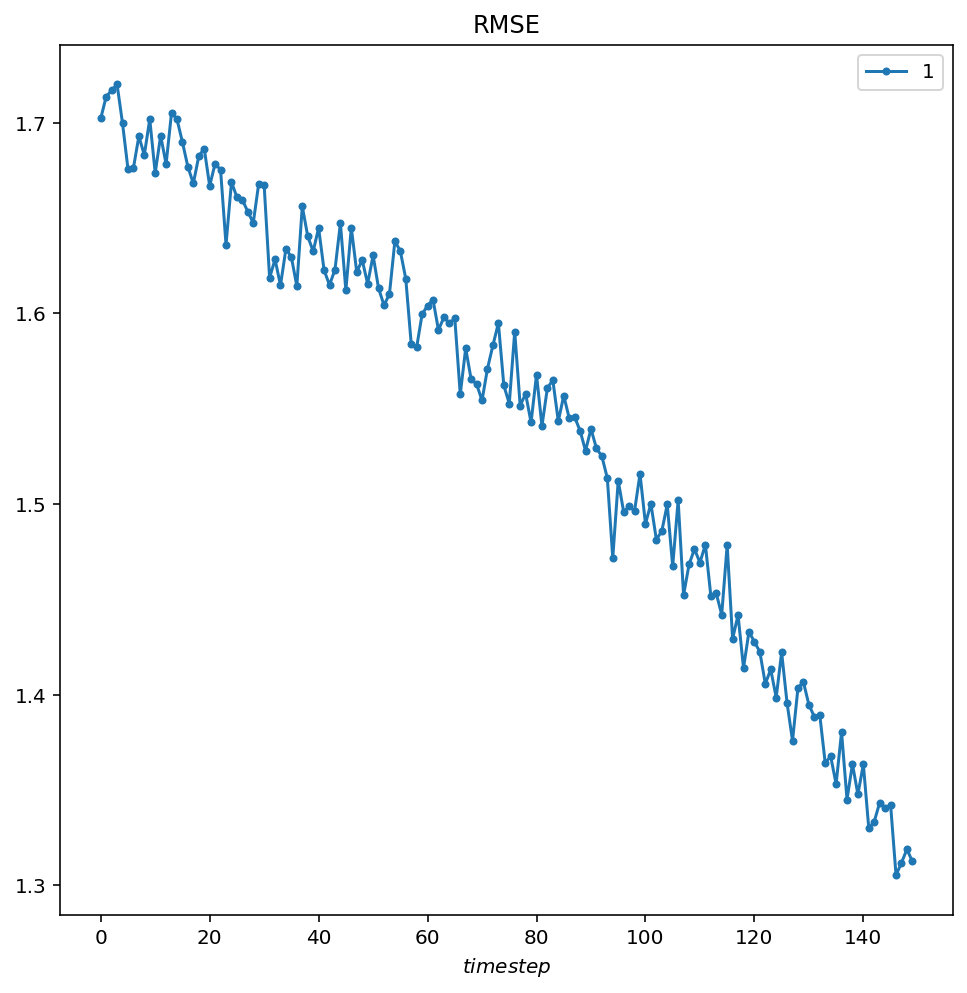

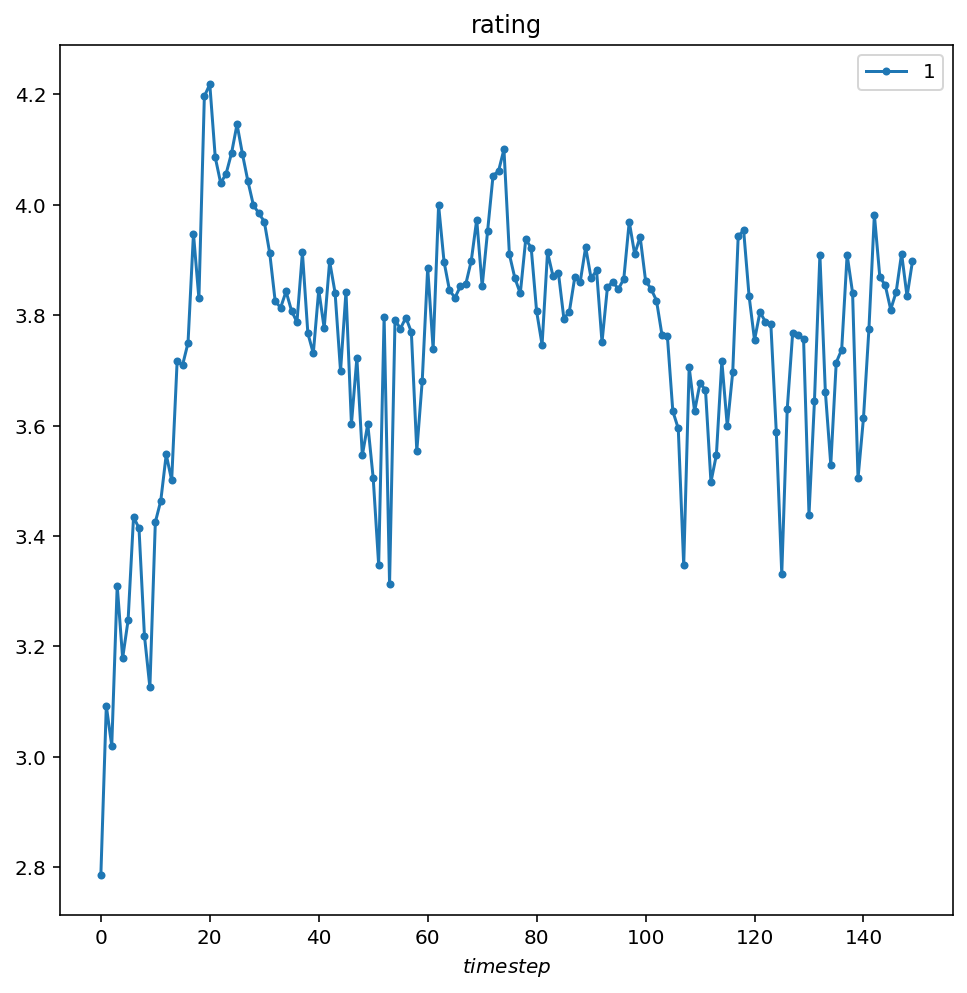

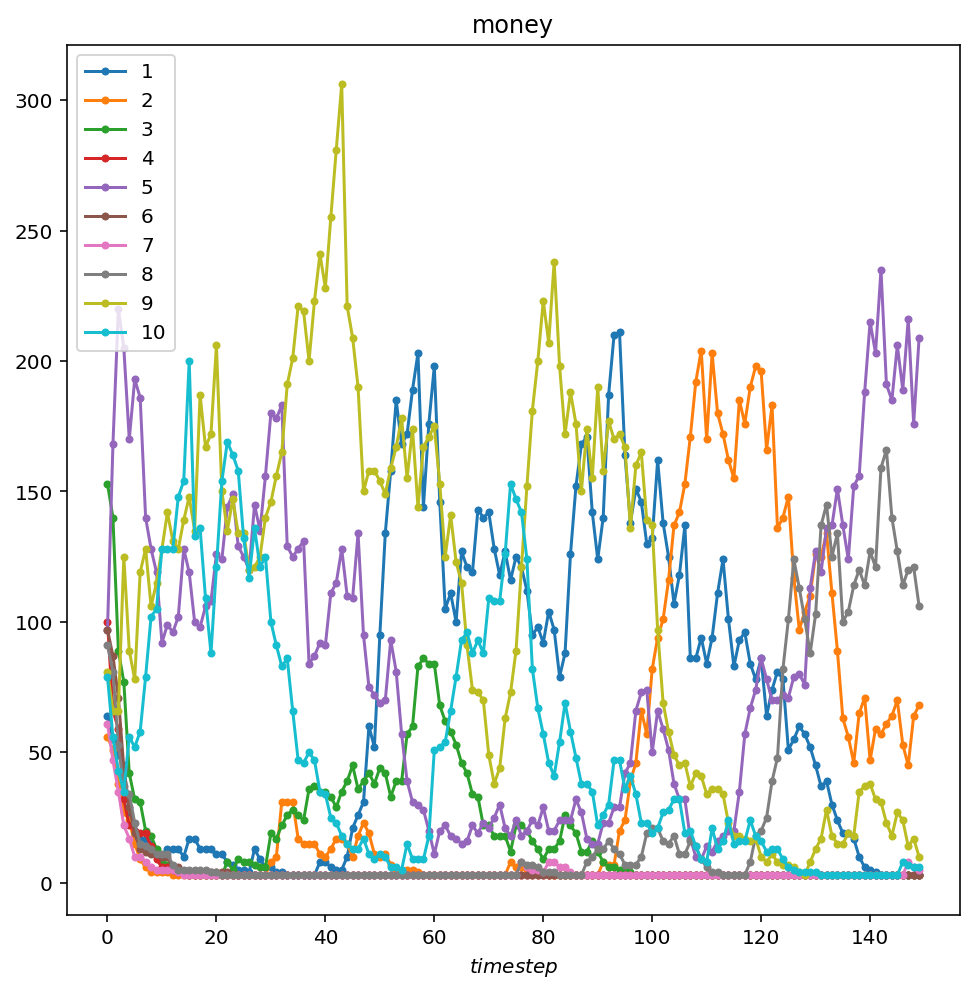

Supplier 0 average amount of money: 71.98666666666666
Suppliers 1:9 average amount of money: 39.894814814814815


In [36]:
NUM_USERS = 100
NUM_ITEMS = 100
NUM_TOPICS = 10
INIT_MONEY = 100
STEPS = 150

# create environment
env_params = {"num_topics": NUM_TOPICS,
              "num_users": NUM_USERS,
              "num_items": NUM_ITEMS,
              "rating_frequency": 0.2,
              "num_init_ratings": NUM_USERS*NUM_ITEMS//100,
              "topic_change": 0}
env = Topics(**env_params)

# create recommender
recommender = LibFM_MLHB(num_user_features=0,
                    num_item_features=0,
                    num_rating_features=0,
                    max_num_users=NUM_USERS,
                    max_num_items=NUM_ITEMS,
                    seed=0)

# initialize environment and recommender
env.seed(0)
items, users, ratings = env.reset()
recommender.reset(items, users, ratings)
env.suppliers = np.full((NUM_TOPICS), INIT_MONEY)
recommender._item_topics = env._item_topics

# run simulation
suppliers, losses, avg_ratings = simulation(env, recommender, steps=STEPS, retrain=True, callbacks=[suppliers_step, RMSE, avg_rec_rating], reset=False)

# plot simulation data
plot_graphs(losses, title='RMSE')
plot_graphs(avg_ratings, title="rating")
plot_graphs(*((np.array(suppliers).T).tolist()), title='money')
print("Supplier 0 average amount of money:", np.mean(np.array(suppliers)[:, 0]))
print("Suppliers 1:9 average amount of money:", np.mean(np.array(suppliers)[:, 1:]))

**Answer**\
Let's compare supplier 7 with supplier 5.\
We think that the game result roughly was determined at the beginning of the simulation - even after the first step.\
Supplier 7 bid too low amount of money, and hence was not recommended, but still lost a considerable portion of his money. This initiated an avalanche of losses, from which he couldn't recover. 
On the other hand, Supplier 5, randomly chosen to use aggressive marketing strategy, won the recommendation at the first iterations and then had enough money to fool around and try different methods.

In [39]:
def suppliers_step(env, recommender):
  assert hasattr(env, 'suppliers')

  # calculates how much money suppliers earned at the current timestep
  def calc_earnings(recommendations):
    topics = env._item_topics[recommendations.flatten()]
    unique, counts = np.unique(topics, return_counts=True)
    earnings = np.zeros_like(env.suppliers)
    earnings[unique] = counts*100//len(topics)
    return earnings

  # generates supplier's biddings
  def calc_spendings():
    spendings = np.zeros_like(env.suppliers)
    spendings[1:] = np.random.randint(low=0, high=env.suppliers[1:]/2)

    # -------------------------------------------------
    # Your code here for question 2
    # spendings[0] = np.random.randint(0, env.suppliers[0]/2)
    # if (spendings[1:].max() + 1) < env.suppliers[0]/2:
    if (np.median(spendings[1:])+1) < env.suppliers[0]/2:
      # spendings[0] = spendings[1:].max() + 1
      spendings[0] = np.median(spendings[1:])+1
    else:
      spendings[0] = np.random.randint(0, env.suppliers[0]/2)
    # -------------------------------------------------
    return spendings
  
  # spend money on promotions
  spendings = calc_spendings()
  env.suppliers -= spendings
  recommender._spendings = spendings

  # get recommendations
  online_users = env.online_users
  recommendations, _ = recommender.recommend(online_users, 1)

  # earn money from recommendations
  earnings = calc_earnings(recommendations)
  env.suppliers += earnings

  return np.copy(env.suppliers)

100%|██████████| 150/150 [00:40<00:00,  3.69it/s]


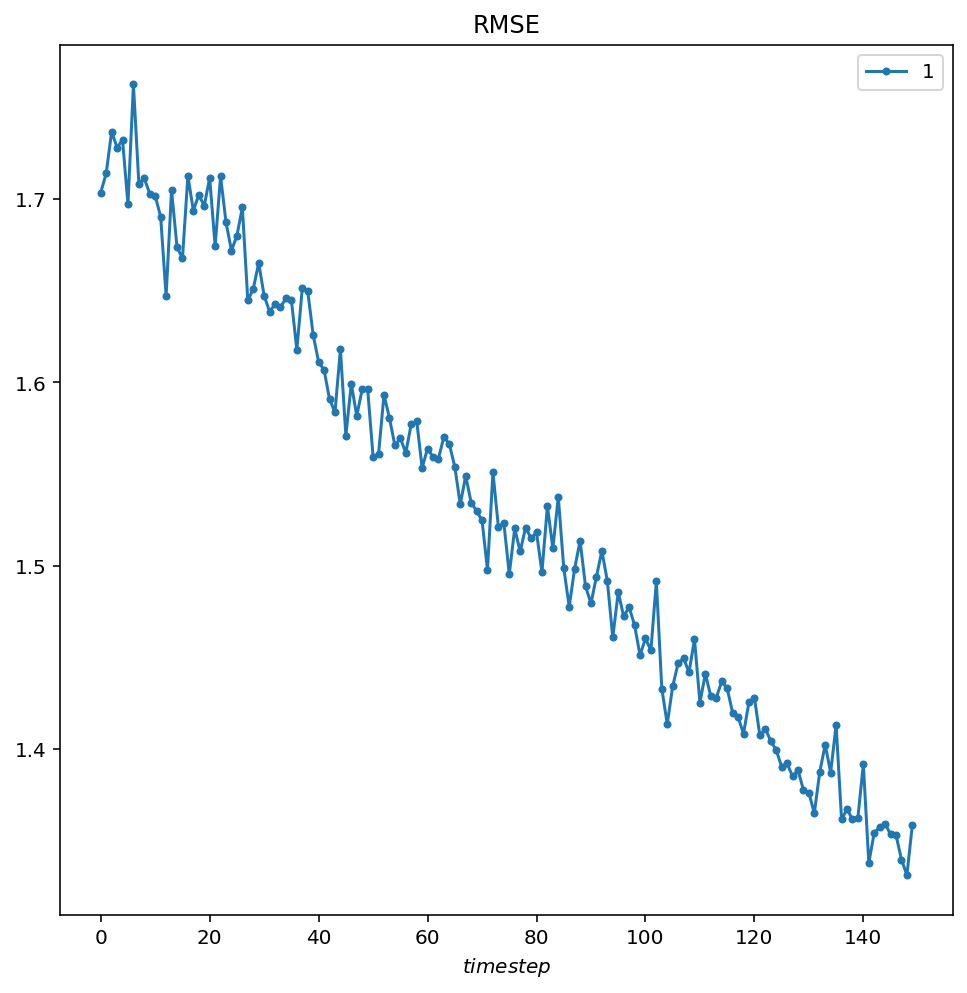

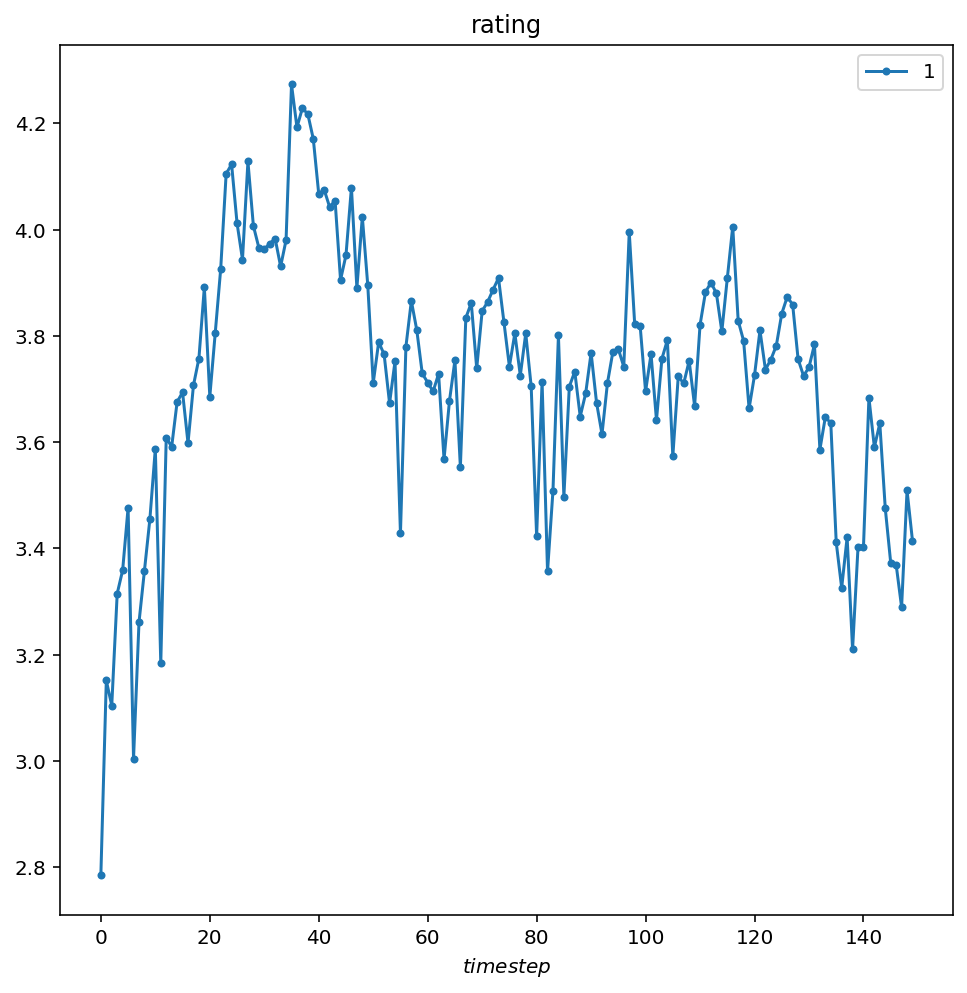

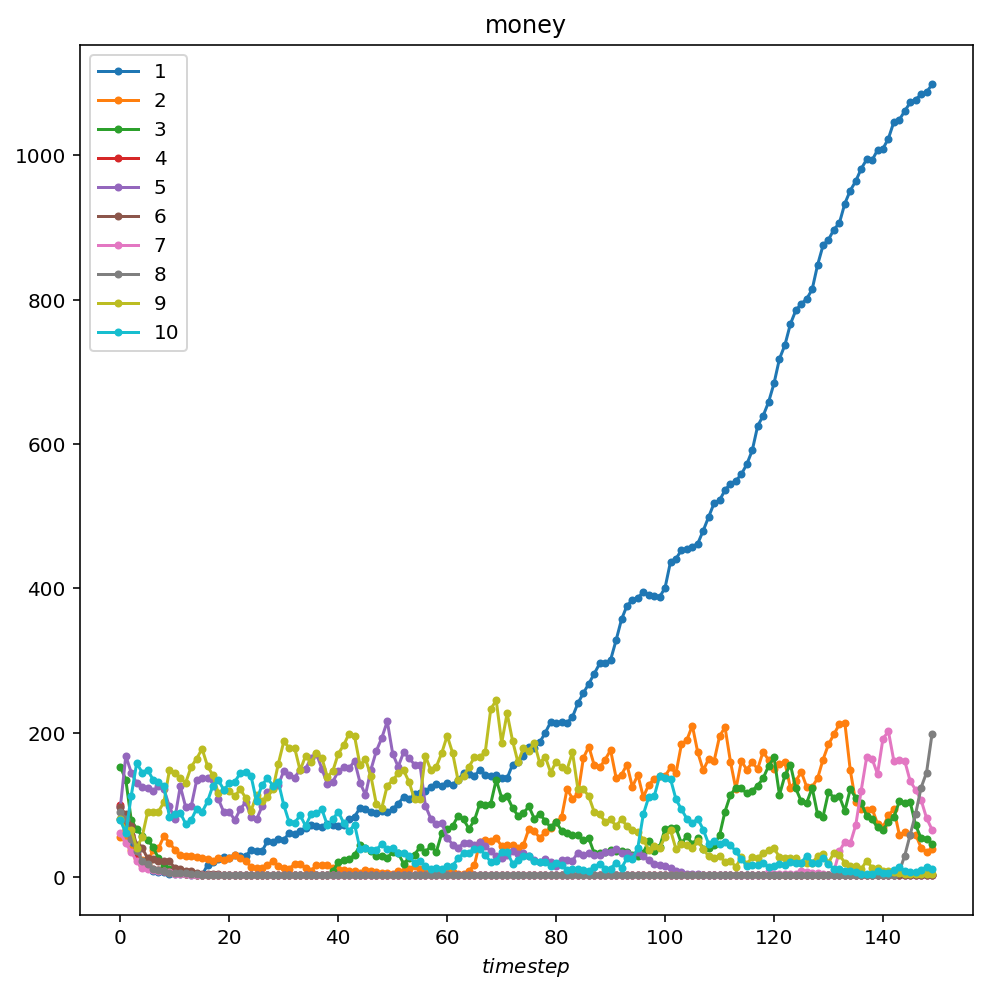

Supplier 0 average amount of money: 340.6666666666667
Suppliers 1:9 average amount of money: 42.86666666666667


In [40]:
# initialize environment and recommender
env.seed(0)
items, users, ratings = env.reset()
recommender.reset(items, users, ratings)
env.suppliers = np.full((NUM_TOPICS), INIT_MONEY)
recommender._item_topics = env._item_topics

# run simulation
suppliers, losses, avg_ratings = simulation(env, recommender, steps=STEPS, retrain=True, callbacks=[suppliers_step, RMSE, avg_rec_rating], reset=False)

# plot simulation data
plot_graphs(losses, title='RMSE')
plot_graphs(avg_ratings, title="rating")
plot_graphs(*((np.array(suppliers).T).tolist()), title='money')
print("Supplier 0 average amount of money:", np.mean(np.array(suppliers)[:, 0]))
print("Suppliers 1:9 average amount of money:", np.mean(np.array(suppliers)[:, 1:]))

**Q2 - Answer**\
Motivated by the previous observation, we suggest our uncle to use the internal knowledge and bid just a little bit more than the median amount of money all the other suppliers suggested. This is a good balance between winning the bidding (and receive the recommendatiofn) and not risking too much money, in case of another supplier bid large amount of money, and win the bidding. 

**Q3 - Answer**\
The new and unfair (unfair to who?) method made most of the other suppliers lose their pants. Only a small fraction of suppliers managed to survive our uncle's bidding strategies. The rest quickly lost all of their money and couldn't recover and left heart-broken and hungry.


In [41]:
def suppliers_step(env, recommender):
  assert hasattr(env, 'suppliers')

  # calculates how much money suppliers earned at the current timestep
  def calc_earnings(recommendations):
    topics = env._item_topics[recommendations.flatten()]
    unique, counts = np.unique(topics, return_counts=True)
    earnings = np.zeros_like(env.suppliers)
    earnings[unique] = counts*100//len(topics)
    return earnings

  # generates supplier's biddings
  def calc_spendings():
    spendings = np.zeros_like(env.suppliers)
    spendings[1:] = np.random.randint(low=0, high=env.suppliers[1:]/2)

    # -------------------------------------------------
    # Your code here for question 4
    if (np.median(env.suppliers[1:]/4)+1) < env.suppliers[0]/2:
      spendings[0] = np.median(env.suppliers[1:]/4)+1
    else:
      spendings[0] = np.random.randint(0, env.suppliers[0]/2)
    # -------------------------------------------------
    return spendings
  
  # spend money on promotions
  spendings = calc_spendings()
  env.suppliers -= spendings
  recommender._spendings = spendings

  # get recommendations
  online_users = env.online_users
  recommendations, _ = recommender.recommend(online_users, 1)

  # earn money from recommendations
  earnings = calc_earnings(recommendations)
  env.suppliers += earnings

  return np.copy(env.suppliers)

100%|██████████| 150/150 [00:40<00:00,  3.70it/s]


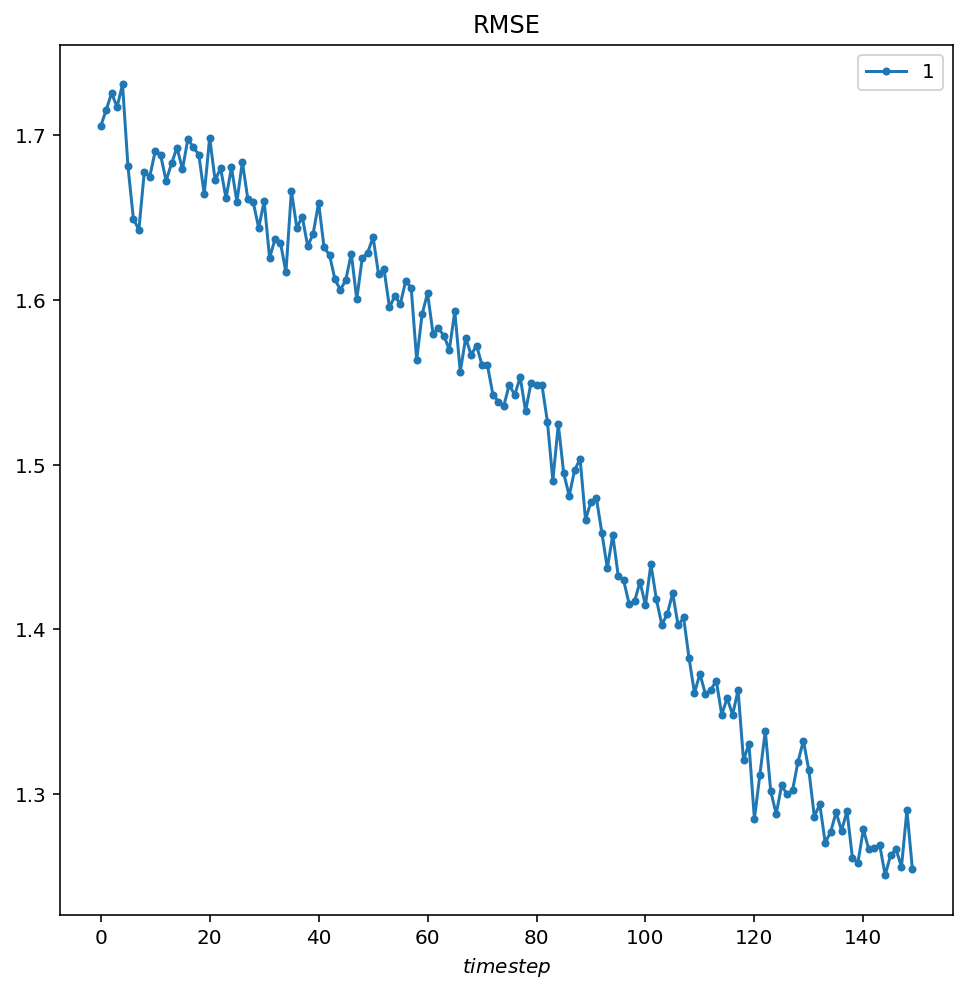

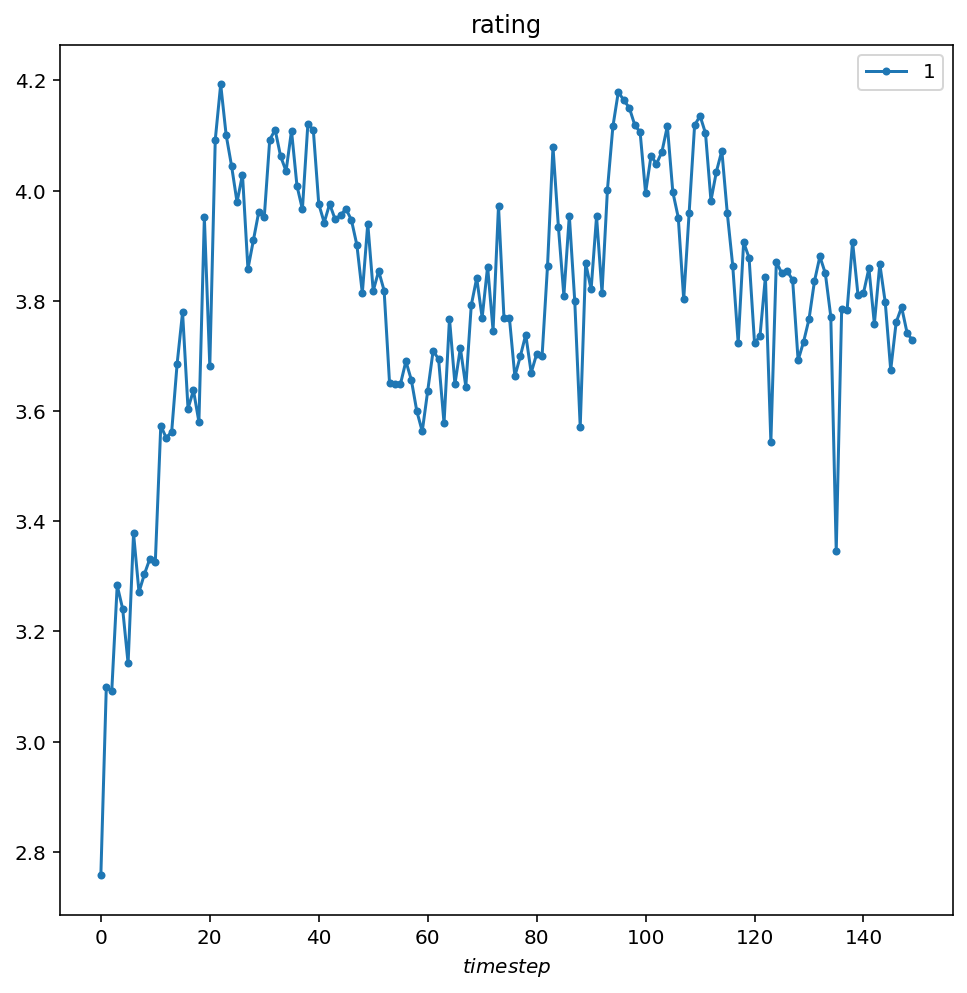

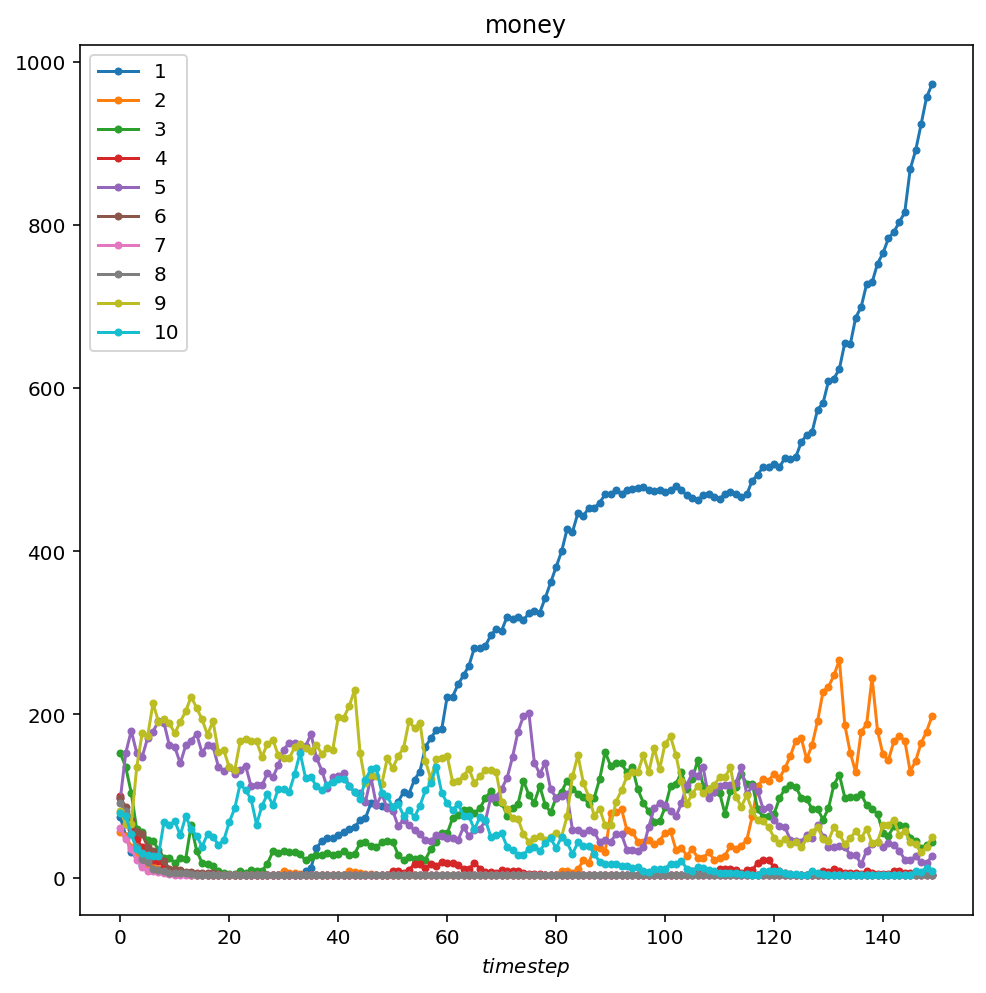

Supplier 0 average amount of money: 318.3666666666667
Suppliers 1:9 average amount of money: 44.595555555555556


In [42]:
# initialize environment and recommender
env.seed(0)
items, users, ratings = env.reset()
recommender.reset(items, users, ratings)
env.suppliers = np.full((NUM_TOPICS), INIT_MONEY)
recommender._item_topics = env._item_topics

# run simulation
suppliers, losses, avg_ratings = simulation(env, recommender, steps=STEPS, retrain=True, callbacks=[suppliers_step, RMSE, avg_rec_rating], reset=False)

# plot simulation data
plot_graphs(losses, title='RMSE')
plot_graphs(avg_ratings, title="rating")
plot_graphs(*((np.array(suppliers).T).tolist()), title='money')
print("Supplier 0 average amount of money:", np.mean(np.array(suppliers)[:, 0]))
print("Suppliers 1:9 average amount of money:", np.mean(np.array(suppliers)[:, 1:]))

**Q4 - Answer**\
Since we no longer have access to other suppliers' bids, we need to find a proxy to estimate their expected bids. We know their budget and their bidding strategy (random uniform distribution between 0 and half their budget); thus, we can approximate their expected bid as one-quarter of each supplier budget, and then apply the same median +1 strategy as before, but calculate the median over the expected values, and not the real bids.  